In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csic-2/anomalous.txt
/kaggle/input/csic-2/normal.txt


In [5]:
print(os.chdir("/kaggle/working/"))

None


In [6]:
import urllib.parse

normal_file_raw = '/kaggle/input/csic-2/normal.txt'
anomalous_file_raw = '/kaggle/input/csic-2/anomalous.txt'

normal_file_pre = '/kaggle/working/normal_url.txt'
anomalous_file_pre = '/kaggle/working/anomalous_url.txt'

In [7]:
def pre_file(file_in, file_out = None):
    with open(file_in, 'r', encoding = 'utf-8') as f_in:
        lines = f_in.readlines()
    res = []
    for i in range(len(lines)):
        line = lines[i].strip()
        # GET type
        if line.startswith("GET"):
            res.append("GET " + line.split(" ")[1])
        # POST type
        elif line.startswith("POST") or line.startswith("PUT"):
            method = line.split(' ')[0]
            url = line.split(' ')[1]
            j = 1
            # get the content of "POST"
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 2
            data = lines[i + j].strip()
            url += '?' + data
            res.append(method + ' ' + url)

    with open(file_out, 'w', encoding='utf-8') as f_out:
        for line in res:
            line = urllib.parse.unquote(line, encoding='ascii', errors='ignore').replace('\n', '').lower()
            f_out.writelines(line + '\n')

    print("{} entries".format(len(res)))


pre_file(normal_file_raw, normal_file_pre)
pre_file(anomalous_file_raw, anomalous_file_pre)

36000 entries
25064 entries


In [8]:
# merge + label
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if len(d) > 0:
            result.append(d)
    return result

normal_requests = load_data('/kaggle/working/normal_url.txt')
anomalous_requests = load_data('/kaggle/working/anomalous_url.txt')

all_requests = normal_requests + anomalous_requests
y_normal = [0] * len(normal_requests)
y_anomalous = [1] * len(anomalous_requests)
y = y_normal + y_anomalous

In [9]:
# 对文本数据进行分类，常用的方法有词袋模型、TF-IDF、词向量化等方法
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.0, analyzer="word", sublinear_tf=True)
X = vectorizer.fit_transform(all_requests)
print(vectorizer.vocabulary_)

{'get': 18621, 'http': 19911, 'localhost': 22120, '8080': 8188, 'tienda1': 29775, 'index': 20264, 'jsp': 20869, 'publico': 26410, 'anadir': 10902, 'id': 20086, 'nombre': 24514, 'jamn': 20606, 'ibrico': 20071, 'precio': 26243, '39': 4353, 'cantidad': 13718, '41': 4643, 'b1': 11782, 'aadir': 9815, 'al': 10304, 'carrito': 13909, 'post': 26180, 'autenticar': 11645, 'modo': 23592, 'entrar': 17019, 'login': 22139, 'caria': 13830, 'pwd': 26501, 'egipciaca': 16684, 'remember': 27010, 'off': 24742, 'caracteristicas': 13780, 'errormsg': 17128, 'credenciales': 15320, 'incorrectas': 20247, 'miembros': 23390, 'pagar': 25213, 'insertar': 20350, '3230': 3674, 'pasar': 25428, 'por': 26129, 'caja': 13475, 'productos': 26335, 'registro': 26957, 'minthorn': 23481, 'password': 25451, 'ahorquillado': 10224, 'isral': 20490, 'apellidos': 11123, 'luna': 22311, 'barberan': 12049, 'email': 16807, 'pouyet': 26198, 'mcrspain': 23120, 'mh': 23350, 'dni': 16245, '83073375c': 8352, 'direccion': 16203, 'calle': 13535

In [10]:
X.shape  # large size

(61064, 31967)

In [11]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [12]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Dara normalization
standardScalar = StandardScaler(with_mean=False)
standardScalar.fit(X_train)
X_train = standardScalar.transform(X_train)
X_test = standardScalar.transform(X_test)


param_grid = [
    {
        'weights': ['uniform'],
        'n_neighbors': [i for i in range(2, 11)] # begin with 2 to avoid overfitting
    },
    {
        'weights': ['distance'],
        'n_neighbors': [i for i in range(2, 11)],
        'p': [i for i in range(1, 6)]
    }
]

# cv 超参
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1, cv=5)

CPU times: user 27.9 ms, sys: 12.2 ms, total: 40.1 ms
Wall time: 40.3 ms


In [13]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_cm(y_test, y_predict):
    sns.set()
    f,ax=plt.subplots()
    C1= confusion_matrix(y_test, y_predict, labels = [0, 1])
    print(C1)
    sns.heatmap(C1,annot=True,ax=ax) # hot plot display

    ax.set_title('confusion matrix') 
    ax.set_xlabel('predict')
    ax.set_ylabel('true')

0.9223238987018515
0.8775055679287305
0.8993567130109982
[[6909  365]
 [ 605 4334]]


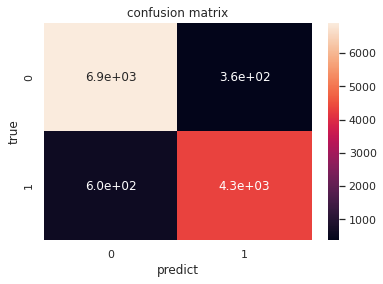

In [15]:
# KNN result

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

y_predict_knn = knn_clf.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_test, y_predict_knn))
print(recall_score(y_test, y_predict_knn))
print(f1_score(y_test, y_predict_knn))

draw_cm(y_test, y_predict_knn)

In [16]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

param_grid = [
    {
        'max_depth':[i for i in range(1, 10)],
        'min_samples_leaf':[i for i in range(1, 20)],
        'min_samples_split':[i for i in range(10, 30)],
    }
]

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, cv=5)

In [17]:
%%time
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)

best_tree_clf = grid_search.best_estimator_
best_tree_clf.score(X_test, y_test)

0.8872284946566025
CPU times: user 38min 39s, sys: 7.71 s, total: 38min 47s
Wall time: 1h 55min 24s


0.879472693032015

In [19]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 19, 'min_samples_split': 11}

In [21]:
y_predict_dt = best_tree_clf.predict(X_test)

print(precision_score(y_test, y_predict_dt))
print(recall_score(y_test, y_predict_dt))
print(f1_score(y_test, y_predict_dt))

0.8281279575998486
0.8858068434905851
0.855996869497163


[[6909  365]
 [ 605 4334]]


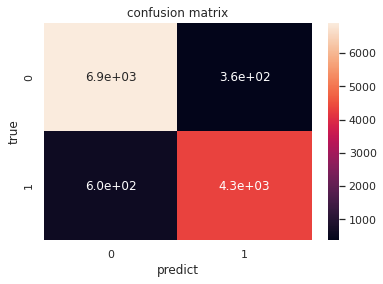

In [22]:
draw_cm(y_test, y_predict_knn)

In [33]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC()

In [32]:
%%time
svm_clf.fit(X_train, y_train)

CPU times: user 8min 2s, sys: 121 ms, total: 8min 2s
Wall time: 8min 2s


SVC()

In [27]:
print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.9750260997727784
0.9602063375092115


0.9639508230881434
0.9366268475399878
0.9500924214417744
[[7101  173]
 [ 313 4626]]


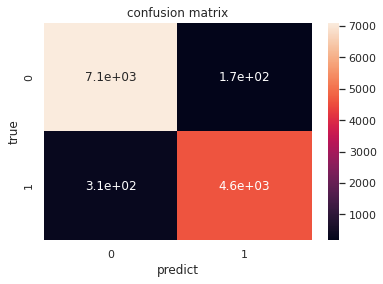

In [28]:
y_predict_svm = svm_clf.predict(X_test)

print(precision_score(y_test, y_predict_svm))
print(recall_score(y_test, y_predict_svm))
print(f1_score(y_test, y_predict_svm))

draw_cm(y_test, y_predict_svm)

In [29]:
# Random Forest
from sklearn.ensemble  import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500,
                               random_state=666,
                               oob_score=True,
                               n_jobs=-1)

In [30]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: user 16min 1s, sys: 928 ms, total: 16min 2s
Wall time: 4min 15s


RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=666)

0.9623578076525336
0.9420935412026726
0.9521178637200737
[[7092  182]
 [ 286 4653]]


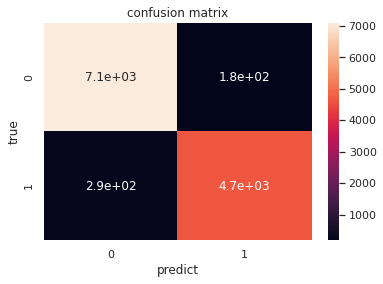

In [31]:
y_predict_rf = rf_clf.predict(X_test)

print(precision_score(y_test, y_predict_rf))
print(recall_score(y_test, y_predict_rf))
print(f1_score(y_test, y_predict_rf))

draw_cm(y_test, y_predict_rf)

In [40]:
# ensemble
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=1000)

In [42]:
%%time
ada_clf.fit(X_train, y_train)

CPU times: user 7min 40s, sys: 73.4 ms, total: 7min 40s
Wall time: 7min 40s


AdaBoostClassifier(n_estimators=1000)

0.9672512148742869
0.9269082810285483
0.9466501240694789
[[7119  155]
 [ 361 4578]]


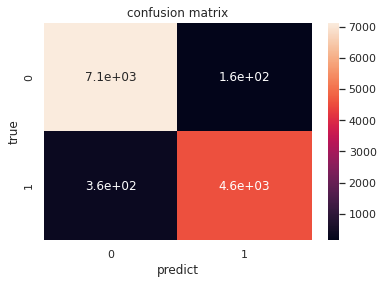

In [44]:
y_predict_ada = ada_clf.predict(X_test)

print(precision_score(y_test, y_predict_ada))
print(recall_score(y_test, y_predict_ada))
print(f1_score(y_test, y_predict_ada))

draw_cm(y_test, y_predict_ada)

In [45]:
# Vectorization. Feature extraction
import re

def vector(data):
    feature = []

    for i in range(len(data)):
        # use split("?", 1) to handle url like http://127.0.0.1/?open=?123
        s = data[i].split("?", 1)
        if len(s) != 1:
            # the length of URL
            url_len = len(data[i])
            
            #request type
            method = data[i].split(" ")[0]
            if method == "get":
                url_method = 1
            elif method == "post":
                url_method = 2
            else:
                url_method = 3
            
            # the length and number of params
            query = s[1]
            parameter_len = len(query)
            parameters = query.split("&")
            parameter_num = len(parameters)
            
            # the max lenth of params
            parameter_max_len = 0
            # number of int in params
            parameter_number_num = 0
            # number of letters in params
            parameter_str_num = 0
            # number of special char in params
            parameter_spe_num = 0
            # the percentage of special char
            par_val_sum = 0

            for parameter in parameters:
                try:
                    # split("=", 1) is to deal with params in form of "open=123=234&file=op"
                    [par_name, par_val] = parameter.split("=", 1)
                except ValueError as err:
                    # params in form of  "?open"
                    print(err)
                    print(data[i])
                    break

                par_val_sum += len(par_val)
                if parameter_max_len < len(par_val):
                    parameter_max_len = len(par_val)
                parameter_number_num += len(re.findall("\d", par_val))
                parameter_str_num += len(re.findall(r"[a-zA-Z]", par_val))
                parameter_spe_num += len(par_val) - len(re.findall("\d", par_val)) - len(
                    re.findall(r"[a-zA-Z]", par_val))

            try:
                parameter_number_rt = parameter_number_num / par_val_sum
                parameter_str_rt = parameter_str_num / par_val_sum
                parameter_spe_rt = parameter_spe_num / par_val_sum
                feature.append([url_len, url_method, parameter_len, parameter_num,
                                parameter_max_len, parameter_number_num, parameter_str_num,
                                parameter_spe_num, parameter_number_rt, parameter_str_rt,
                                parameter_spe_rt])
            except ZeroDivisionError as err:
                print(err)
                print(data[i])
                continue
    return feature

In [46]:
vector(normal_requests)  # type is numpy

not enough values to unpack (expected 2, got 1)
get http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=dpnq&a&password=co2g355inacin&nombre=crispino&apellidos=ozcoz+villamil&email=anglade@teamspanish.my&dni=95375570k&direccion=juan+de+arguelles+71+&ciudad=moros&cp=16336&provincia=zamora&ntc=3155444527951741&b1=registrar
not enough values to unpack (expected 2, got 1)
post: http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=dpnq&a&password=co2g355inacin&nombre=crispino&apellidos=ozcoz+villamil&email=anglade@teamspanish.my&dni=95375570k&direccion=juan+de+arguelles+71+&ciudad=moros&cp=16336&provincia=zamora&ntc=3155444527951741&b1=registrar


[[118, 1, 65, 5, 16, 5, 24, 3, 0.15625, 0.75, 0.09375],
 [120, 3, 65, 5, 16, 5, 24, 3, 0.15625, 0.75, 0.09375],
 [117, 1, 60, 5, 9, 0, 29, 0, 0.0, 1.0, 0.0],
 [119, 3, 60, 5, 9, 0, 29, 0, 0.0, 1.0, 0.0],
 [66, 1, 4, 1, 1, 1, 0, 0, 1.0, 0.0, 0.0],
 [68, 3, 4, 1, 1, 1, 0, 0, 1.0, 0.0, 0.0],
 [86, 1, 33, 1, 24, 0, 23, 1, 0.0, 0.9583333333333334, 0.041666666666666664],
 [88, 3, 33, 1, 24, 0, 23, 1, 0.0, 0.9583333333333334, 0.041666666666666664],
 [95,
  1,
  43,
  3,
  14,
  4,
  20,
  2,
  0.15384615384615385,
  0.7692307692307693,
  0.07692307692307693],
 [97,
  3,
  43,
  3,
  14,
  4,
  20,
  2,
  0.15384615384615385,
  0.7692307692307693,
  0.07692307692307693],
 [291,
  1,
  236,
  13,
  19,
  31,
  102,
  7,
  0.22142857142857142,
  0.7285714285714285,
  0.05],
 [293,
  3,
  236,
  13,
  19,
  31,
  102,
  7,
  0.22142857142857142,
  0.7285714285714285,
  0.05],
 [70, 1, 17, 1, 14, 0, 13, 1, 0.0, 0.9285714285714286, 0.07142857142857142],
 [72, 3, 17, 1, 14, 0, 13, 1, 0.0, 0.92857142

In [47]:
vector(anomalous_requests)

not enough values to unpack (expected 2, got 1)
post: http://localhost:8080/tienda1/publico/pagar.jsp?
division by zero
post: http://localhost:8080/tienda1/publico/pagar.jsp?
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?open
division by zero
get http://localhost:8080/?open
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?open
division by zero
get http://localhost:8080/?open
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?openserver
division by zero
get http://localhost:8080/?openserver
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?openserver
division by zero
get http://localhost:8080/?openserver
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?open
division by zero
get http://localhost:8080/?open
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?openserver
division by zero
get http://localhost:8080/?openserver
not enough valu

[[180,
  1,
  127,
  5,
  64,
  3,
  71,
  20,
  0.031914893617021274,
  0.7553191489361702,
  0.2127659574468085],
 [182,
  3,
  127,
  5,
  64,
  3,
  71,
  20,
  0.031914893617021274,
  0.7553191489361702,
  0.2127659574468085],
 [119,
  1,
  66,
  5,
  16,
  5,
  24,
  4,
  0.15151515151515152,
  0.7272727272727273,
  0.12121212121212122],
 [121,
  3,
  66,
  5,
  16,
  5,
  24,
  4,
  0.15151515151515152,
  0.7272727272727273,
  0.12121212121212122],
 [159,
  1,
  102,
  5,
  48,
  6,
  55,
  10,
  0.08450704225352113,
  0.7746478873239436,
  0.14084507042253522],
 [161,
  3,
  102,
  5,
  48,
  6,
  55,
  10,
  0.08450704225352113,
  0.7746478873239436,
  0.14084507042253522],
 [120, 1, 63, 5, 10, 0, 29, 3, 0.0, 0.90625, 0.09375],
 [122, 3, 63, 5, 10, 0, 29, 3, 0.0, 0.90625, 0.09375],
 [120, 1, 63, 5, 9, 6, 25, 0, 0.1935483870967742, 0.8064516129032258, 0.0],
 [122, 3, 63, 5, 9, 6, 25, 0, 0.1935483870967742, 0.8064516129032258, 0.0],
 [67, 1, 5, 1, 1, 1, 0, 0, 1.0, 0.0, 0.0],
 [6

In [49]:
# save as csv files

vec_path1 = '/kaggle/working/vec_normal.txt'
vec_path2 = '/kaggle/working/vec_anomalous.txt'

vec_path11 = '/kaggle/working/vec_normal.csv'
vec_path22 = '/kaggle/working/vec_anomalous.csv'
vec_path33 = '/kaggle/working/vec_all.csv'

matrix_normal = vector(normal_requests)
matrix_anomalous = vector(anomalous_requests)

np.savetxt(vec_path1, matrix_normal)
np.savetxt(vec_path2, matrix_anomalous)
np.savetxt(vec_path11, matrix_normal, delimiter=',')
np.savetxt(vec_path22, matrix_anomalous, delimiter=',')

all_requests = np.concatenate([matrix_normal, matrix_anomalous])
np.savetxt(vec_path33, all_requests, delimiter=',')

not enough values to unpack (expected 2, got 1)
get http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=dpnq&a&password=co2g355inacin&nombre=crispino&apellidos=ozcoz+villamil&email=anglade@teamspanish.my&dni=95375570k&direccion=juan+de+arguelles+71+&ciudad=moros&cp=16336&provincia=zamora&ntc=3155444527951741&b1=registrar
not enough values to unpack (expected 2, got 1)
post: http://localhost:8080/tienda1/publico/registro.jsp?modo=registro&login=dpnq&a&password=co2g355inacin&nombre=crispino&apellidos=ozcoz+villamil&email=anglade@teamspanish.my&dni=95375570k&direccion=juan+de+arguelles+71+&ciudad=moros&cp=16336&provincia=zamora&ntc=3155444527951741&b1=registrar
not enough values to unpack (expected 2, got 1)
post: http://localhost:8080/tienda1/publico/pagar.jsp?
division by zero
post: http://localhost:8080/tienda1/publico/pagar.jsp?
not enough values to unpack (expected 2, got 1)
get http://localhost:8080/?open
division by zero
get http://localhost:8080/?open
not enough